In [2]:
#!pip install keras
#!pip install numpy
#!pip install imageio
#!pip install matplotlib
#!pip install opencv-python

import threading
import sys
import cv2
import sys
import os
import csv
import itertools
import numpy as np
from PIL import Image
import imageio
import itertools as it
import tensorflow as tf
import keras
print("Keras version %s" % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

print("Tensorflow version %s" % tf.__version__)

import pprint
pp = pprint.PrettyPrinter(depth=6)

Using TensorFlow backend.


Keras version 2.0.4
Tensorflow version 1.1.0


In [3]:
# Add the standard include path for FoosMetrics
sys.path.insert(0, './../Code')

import importlib
import process
importlib.reload(process)

<module 'process' from './../Code\\process.py'>

In [4]:
# Load the data and frames, and add the normalizer
training = process.Processor("data_loader_training.json")
validation = process.Processor("data_loader_validation.json")

Creating transform: random_video_loader
Adding folder '.\..\TrainingData\Processed\BallTracking\'
'.\..\TrainingData\Processed\BallTracking\balltracking_0.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_1.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_2.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_3.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_4.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_5.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_6.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_7.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_8.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_9.avi': 4073 frames found.
Loaded 75258 frames in random loader.
Distribution:
{'balltracking_.avi':

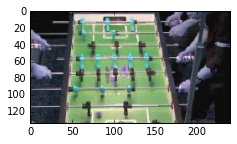

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


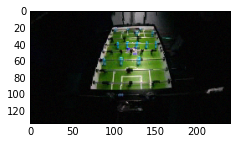

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]])


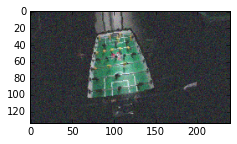

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])


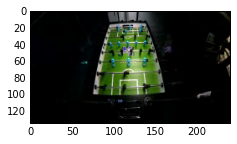

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


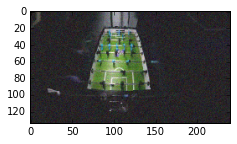

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


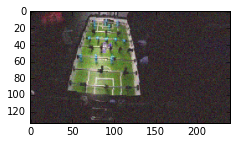

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])


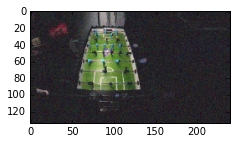

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


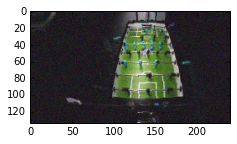

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


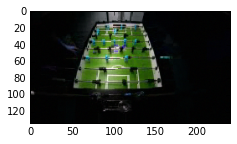

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


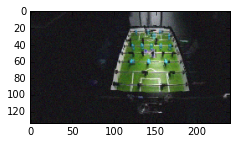

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


In [5]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# View the first few frames
for k in range(10):
    data = training.get_next_frame()
    frame = data["frame"]
    fig, ax = plt.subplots(figsize=(18, 2))
    plt.imshow(frame)
    plt.show()
    pp.pprint( np.transpose( np.array(data["values"] ) ))

In [6]:
# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
class threadsafe_iter(object):
  """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
  def __init__(self, it):
      self.it = it
      self.lock = threading.Lock()

  def __iter__(self):
      return self

  def __next__(self):
      with self.lock:
          return self.it.__next__()

# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
def threadsafe_generator(f):
  """
    A decorator that takes a generator function and makes it thread-safe.
    """
  def g(*a, **kw):
      return threadsafe_iter(f(*a, **kw))
  return g


# Define our training and validation iterators
@threadsafe_generator
def TrainGen(training):
    while True:
        data = training.get_next_frame()
        if data is not None:
            frame = data["frame"]
            output = np.array(data["values"])

            while frame is not None:
                yield (frame, output)
                data = training.get_next_frame()
                if data is not None:
                    frame = data["frame"]
                    output = np.array(data["values"])
                else:
                    frame = None
                
             
# Generators for training the position
@threadsafe_generator
def TrainBatchGen(batch_size, training):
    gen = TrainGen(training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 9), dtype=np.float32)
        for i in range(batch_size):
            (frame, output) = next(gen)
            batch_frames[i,:,:,:] = frame
            batch_outputs[i,:] = output[:,0]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

                
             
# Generators for training the position
@threadsafe_generator
def ValidationBatchGen(batch_size, validation):
    gen = TrainGen(validation)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 9), dtype=np.float32)
        for i in range(batch_size):
            (frame, output) = next(gen)
            batch_frames[i,:,:,:] = frame
            batch_outputs[i,:] = output[:,0]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
        
    
    
        
    


In [7]:
# Utilities for plotting the result and training
def plot_validate(generator, model, count, name):   
    outputs_predicted = None
    outputs_true = None
    
    while outputs_predicted is None or outputs_predicted.shape[0] < count:
        
        (new_frames, new_outputs_true) = next(generator)
        if outputs_true is None:
            outputs_true = new_outputs_true
        else:
            outputs_true = np.concatenate( (outputs_true, new_outputs_true), axis=0 )
        
        
        new_outputs_predicted = model.predict(new_frames, batch_size=new_frames.shape[0], verbose=0)
        if outputs_predicted is None:
            outputs_predicted = new_outputs_predicted
        else:
            outputs_predicted = np.concatenate( (outputs_predicted, new_outputs_predicted), axis=0 )
    
    
    f, axes = plt.subplots(outputs_true.shape[1], figsize=(12, 12), sharex=True, sharey=True)
    
    for i in range(outputs_true.shape[1]):
        true, predicted = zip(*sorted(zip(outputs_true[0:count,i], outputs_predicted[0:count,i])))
        axes[i].plot(range(count),true, label="True position" )
        axes[i].plot(range(count),predicted, label="Predicted position" )
        #axes[i].ylabel("Rod %i" % (i))
        axes[i].grid(False)
        if i == 0:
            axes[i].legend()
            axes[i].set_title(name)
            
    
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    
    
    plt.show()

    
    



In [ ]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model



image_height       = 134
image_width        = 240
image_channels     = 3

# Model options
batch_size = 10
lstm_output_size = 300
cnn_kernel_count = 40

# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_height, image_width, image_channels))

# Used to give fixed names to the layers for transferring the model
conv_num = 0 
pool_num = 0
dense_num = 0

# Build a functional model design
inputs = Input(shape=(image_height, image_width, image_channels,),
              name="Input")
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "conv2d_%i"%conv_num)(inputs)
conv_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "conv2d_%i"%conv_num)(x)
conv_num+=1

# Split into a horizontal detail and vertical detailed CNN paths
x = MaxPooling2D( pool_size=(1, 2),
                  name = "max_pooling2d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1

x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1


#x = Flatten()(x)
#x = Reshape((number_of_frames,6*6*cnn_kernel_count))(x)
x = Flatten()(x)


x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(64, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
predictions = Dense(9, activation='softmax',name="dense_%i"%dense_num)(x)
dense_num+=1

model = Model(inputs=inputs, outputs=predictions)


# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00001),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


model.summary()

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = '.\\Goalie3Frames\\weights_%i.hdf'
MODELS_FNAME = '.\\Goalie3Frames\\models_%i.h5'

'Input shape without batches:'
(134, 240, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 134, 240, 3)       0         
_________________________________________________________________
conv2d_0 (Conv2D)            (None, 134, 240, 40)      1120      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 134, 240, 40)      14440     
_________________________________________________________________
max_pooling2d_0 (MaxPooling2 (None, 134, 120, 40)      0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 134, 120, 40)      14440     
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 134, 120, 40)      14440     
_________________________________________________________________
max_pooling3d_1 (MaxPooling2 (N

Batch size 20: 752 training batches, 188 validation batches
Epoch 1/1
753/752 [==============================] - 232s - loss: 2.1528 - categorical_accuracy: 0.1550 - val_loss: 2.0916 - val_categorical_accuracy: 0.2093


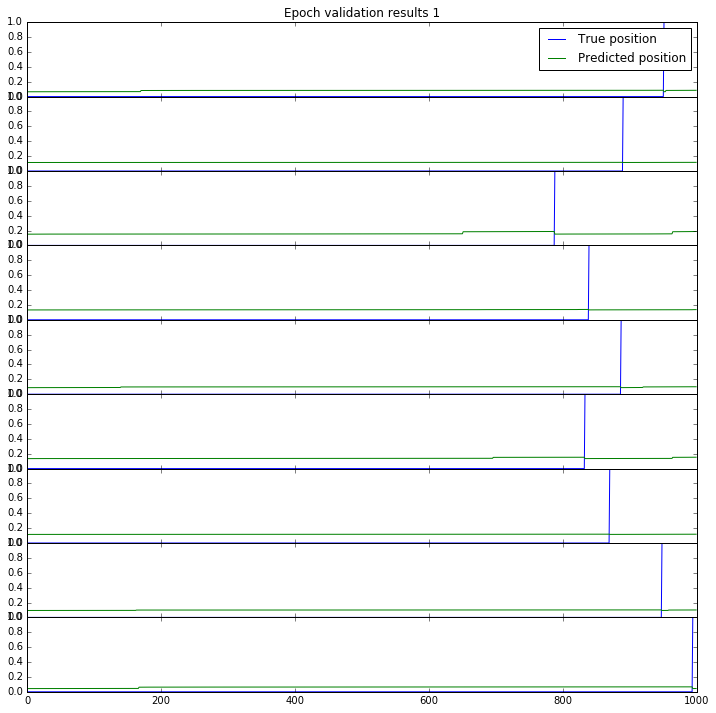

Wrote model to .\Models\weights_1.hdf
Epoch 2/2
753/752 [==============================] - 230s - loss: 2.1174 - categorical_accuracy: 0.1660 - val_loss: 2.0752 - val_categorical_accuracy: 0.2239
Wrote model to .\Models\weights_2.hdf
Epoch 3/3
753/752 [==============================] - 232s - loss: 2.1065 - categorical_accuracy: 0.1751 - val_loss: 2.0633 - val_categorical_accuracy: 0.2093
Wrote model to .\Models\weights_3.hdf
Epoch 4/4
753/752 [==============================] - 230s - loss: 2.0978 - categorical_accuracy: 0.1762 - val_loss: 2.0595 - val_categorical_accuracy: 0.2045
Wrote model to .\Models\weights_4.hdf
Epoch 5/5
753/752 [==============================] - 229s - loss: 2.0914 - categorical_accuracy: 0.1776 - val_loss: 2.0485 - val_categorical_accuracy: 0.2173
Wrote model to .\Models\weights_5.hdf
Epoch 6/6
753/752 [==============================] - 231s - loss: 2.0904 - categorical_accuracy: 0.1848 - val_loss: 2.0429 - val_categorical_accuracy: 0.2205
Wrote model to .\Mod

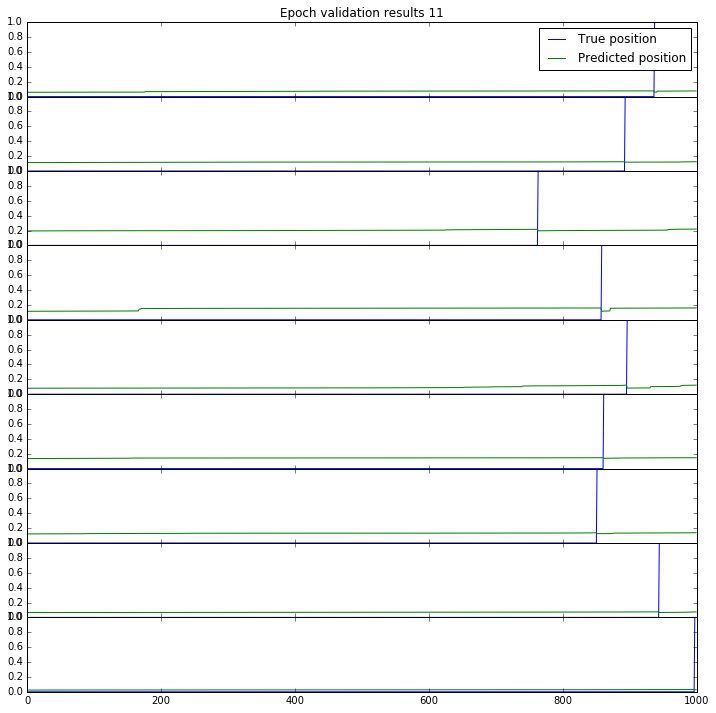

Wrote model to .\Models\weights_11.hdf
Epoch 12/12
753/752 [==============================] - 230s - loss: 2.0596 - categorical_accuracy: 0.1934 - val_loss: 1.9960 - val_categorical_accuracy: 0.2173
Wrote model to .\Models\weights_12.hdf
Epoch 13/13
753/752 [==============================] - 231s - loss: 2.0592 - categorical_accuracy: 0.1867 - val_loss: 2.0034 - val_categorical_accuracy: 0.2114
Wrote model to .\Models\weights_13.hdf
Epoch 14/14
753/752 [==============================] - 232s - loss: 2.0507 - categorical_accuracy: 0.1924 - val_loss: 1.9828 - val_categorical_accuracy: 0.2077
Wrote model to .\Models\weights_14.hdf
Epoch 15/15
753/752 [==============================] - 230s - loss: 2.0470 - categorical_accuracy: 0.1977 - val_loss: 1.9598 - val_categorical_accuracy: 0.2165
Wrote model to .\Models\weights_15.hdf
Epoch 16/16
753/752 [==============================] - 231s - loss: 2.0387 - categorical_accuracy: 0.1968 - val_loss: 1.9543 - val_categorical_accuracy: 0.2298
Wrote

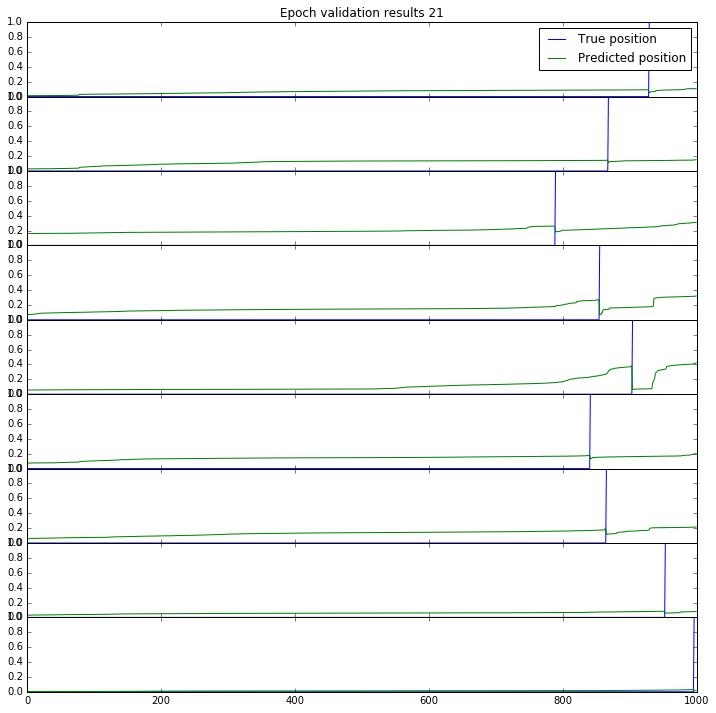

Wrote model to .\Models\weights_21.hdf
Epoch 22/22
753/752 [==============================] - 230s - loss: 1.9693 - categorical_accuracy: 0.2448 - val_loss: 1.7125 - val_categorical_accuracy: 0.4096
Wrote model to .\Models\weights_22.hdf
Epoch 23/23
753/752 [==============================] - 230s - loss: 1.9504 - categorical_accuracy: 0.2531 - val_loss: 1.6532 - val_categorical_accuracy: 0.4596
Wrote model to .\Models\weights_23.hdf
Epoch 24/24
753/752 [==============================] - 231s - loss: 1.9324 - categorical_accuracy: 0.2613 - val_loss: 1.5867 - val_categorical_accuracy: 0.5037
Wrote model to .\Models\weights_24.hdf
Epoch 25/25
753/752 [==============================] - 232s - loss: 1.9145 - categorical_accuracy: 0.2725 - val_loss: 1.5387 - val_categorical_accuracy: 0.5197
Wrote model to .\Models\weights_25.hdf
Epoch 26/26
753/752 [==============================] - 230s - loss: 1.8908 - categorical_accuracy: 0.2856 - val_loss: 1.4649 - val_categorical_accuracy: 0.5455
Wrote

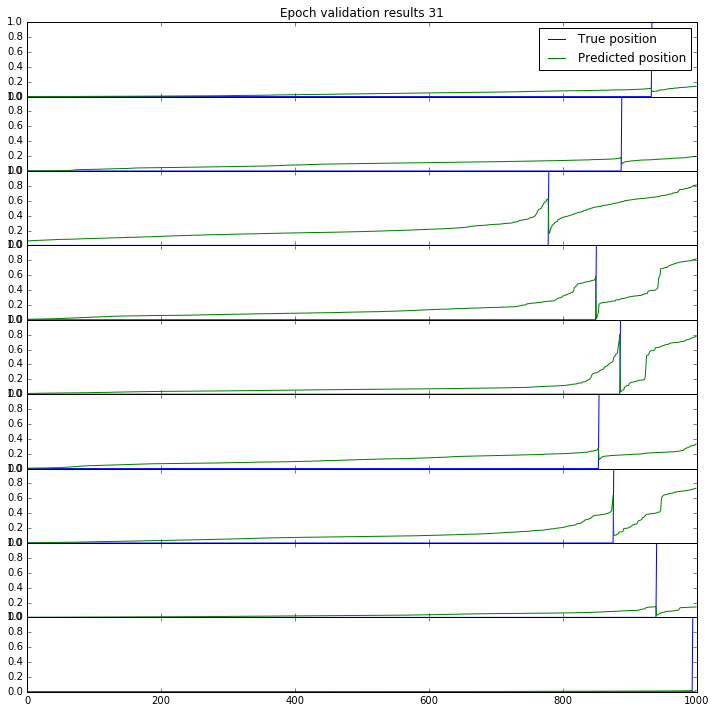

Wrote model to .\Models\weights_31.hdf
Epoch 32/32
753/752 [==============================] - 231s - loss: 1.7799 - categorical_accuracy: 0.3323 - val_loss: 1.1965 - val_categorical_accuracy: 0.6234
Wrote model to .\Models\weights_32.hdf
Epoch 33/33
753/752 [==============================] - 230s - loss: 1.7787 - categorical_accuracy: 0.3294 - val_loss: 1.1586 - val_categorical_accuracy: 0.6207
Wrote model to .\Models\weights_33.hdf
Epoch 34/34
753/752 [==============================] - 230s - loss: 1.7620 - categorical_accuracy: 0.3385 - val_loss: 1.0982 - val_categorical_accuracy: 0.6322
Wrote model to .\Models\weights_34.hdf
Epoch 35/35
753/752 [==============================] - 229s - loss: 1.7366 - categorical_accuracy: 0.3500 - val_loss: 1.0819 - val_categorical_accuracy: 0.6399
Wrote model to .\Models\weights_35.hdf
Epoch 36/36
753/752 [==============================] - 229s - loss: 1.7287 - categorical_accuracy: 0.3570 - val_loss: 1.0330 - val_categorical_accuracy: 0.6652
Wrote

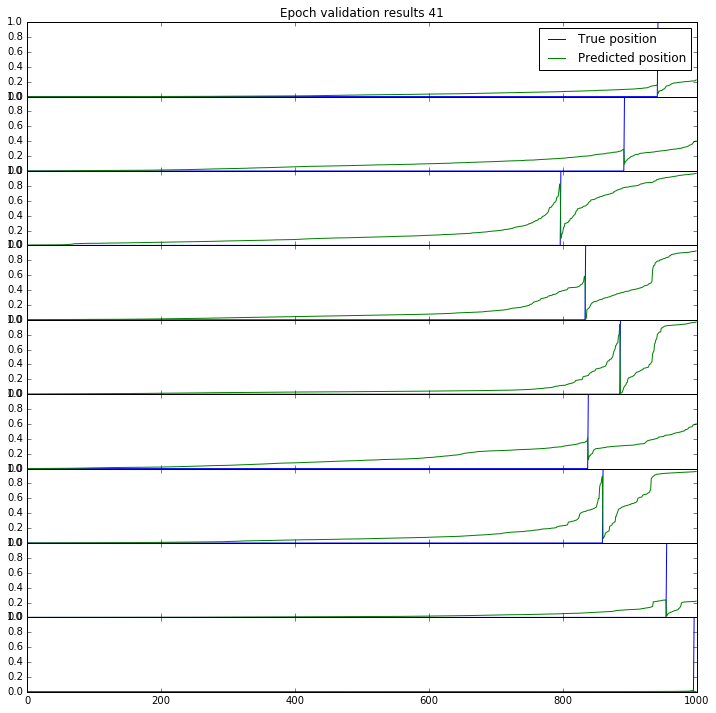

Wrote model to .\Models\weights_41.hdf
Epoch 42/42
753/752 [==============================] - 229s - loss: 1.6333 - categorical_accuracy: 0.3975 - val_loss: 0.9188 - val_categorical_accuracy: 0.6713
Wrote model to .\Models\weights_42.hdf
Epoch 43/43
753/752 [==============================] - 231s - loss: 1.6467 - categorical_accuracy: 0.3894 - val_loss: 0.8671 - val_categorical_accuracy: 0.6926
Wrote model to .\Models\weights_43.hdf
Epoch 44/44
753/752 [==============================] - 230s - loss: 1.6209 - categorical_accuracy: 0.4013 - val_loss: 0.8125 - val_categorical_accuracy: 0.7202
Wrote model to .\Models\weights_44.hdf
Epoch 45/45
753/752 [==============================] - 229s - loss: 1.6107 - categorical_accuracy: 0.4080 - val_loss: 0.8658 - val_categorical_accuracy: 0.7205
Wrote model to .\Models\weights_45.hdf
Epoch 46/46
753/752 [==============================] - 229s - loss: 1.5791 - categorical_accuracy: 0.4142 - val_loss: 0.7697 - val_categorical_accuracy: 0.7532
Wrote

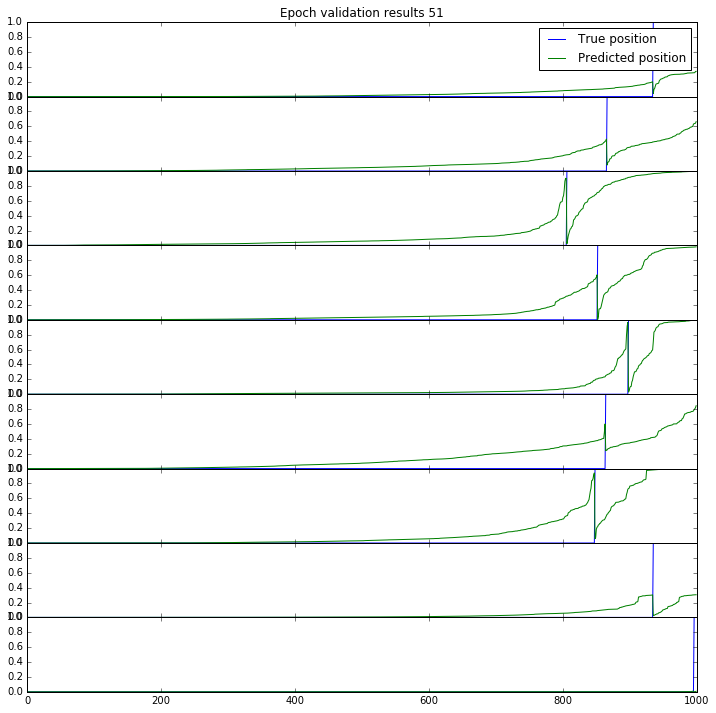

Wrote model to .\Models\weights_51.hdf
Epoch 52/52
753/752 [==============================] - 231s - loss: 1.5438 - categorical_accuracy: 0.4339 - val_loss: 0.7335 - val_categorical_accuracy: 0.7707
Wrote model to .\Models\weights_52.hdf
Epoch 53/53
753/752 [==============================] - 231s - loss: 1.5281 - categorical_accuracy: 0.4386 - val_loss: 0.6911 - val_categorical_accuracy: 0.8035
Transform of type 'VideoLoaderRandom' returned None.
Wrote model to .\Models\weights_53.hdf
Epoch 54/54
753/752 [==============================] - 230s - loss: 1.5046 - categorical_accuracy: 0.4441 - val_loss: 0.6701 - val_categorical_accuracy: 0.7827
Wrote model to .\Models\weights_54.hdf
Epoch 55/55
753/752 [==============================] - 230s - loss: 1.4815 - categorical_accuracy: 0.4588 - val_loss: 0.6656 - val_categorical_accuracy: 0.8016
Wrote model to .\Models\weights_55.hdf
Epoch 56/56
753/752 [==============================] - 230s - loss: 1.4833 - categorical_accuracy: 0.4572 - val_

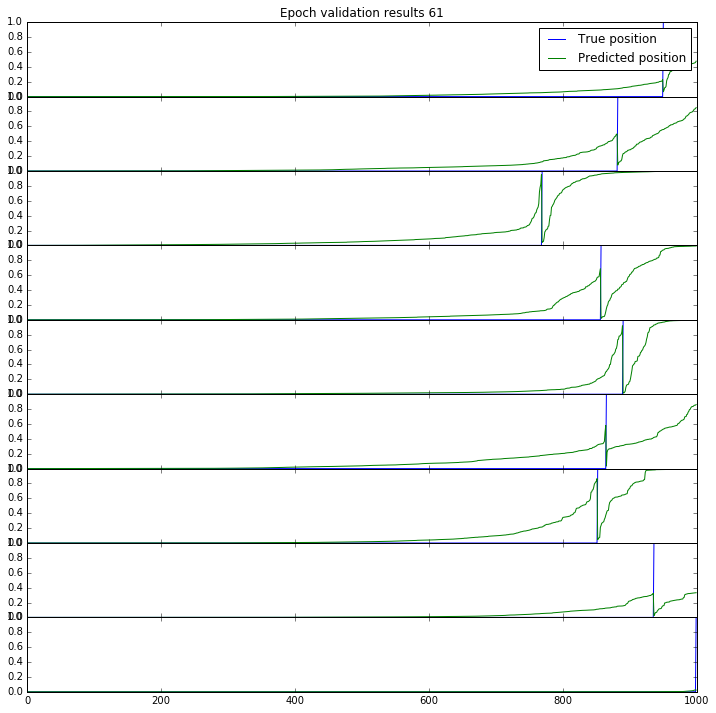

Wrote model to .\Models\weights_61.hdf
Epoch 62/62
753/752 [==============================] - 230s - loss: 1.4195 - categorical_accuracy: 0.4790 - val_loss: 0.5691 - val_categorical_accuracy: 0.8311
Wrote model to .\Models\weights_62.hdf
Epoch 63/63
753/752 [==============================] - 231s - loss: 1.4068 - categorical_accuracy: 0.4873 - val_loss: 0.5555 - val_categorical_accuracy: 0.8420
Wrote model to .\Models\weights_63.hdf
Epoch 64/64
753/752 [==============================] - 232s - loss: 1.3929 - categorical_accuracy: 0.4861 - val_loss: 0.5361 - val_categorical_accuracy: 0.8513
Wrote model to .\Models\weights_64.hdf
Epoch 65/65
753/752 [==============================] - 229s - loss: 1.3965 - categorical_accuracy: 0.4908 - val_loss: 0.5260 - val_categorical_accuracy: 0.8415
Wrote model to .\Models\weights_65.hdf
Epoch 66/66
753/752 [==============================] - 229s - loss: 1.3774 - categorical_accuracy: 0.4956 - val_loss: 0.5472 - val_categorical_accuracy: 0.8364
Wrote

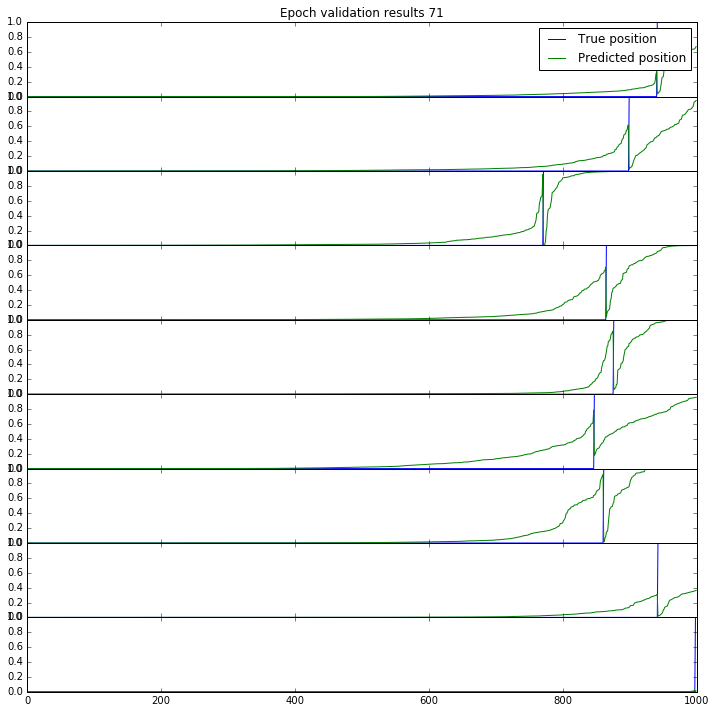

Wrote model to .\Models\weights_71.hdf
Epoch 72/72
753/752 [==============================] - 232s - loss: 1.3154 - categorical_accuracy: 0.5158 - val_loss: 0.5015 - val_categorical_accuracy: 0.8540
Wrote model to .\Models\weights_72.hdf
Epoch 73/73
753/752 [==============================] - 231s - loss: 1.3107 - categorical_accuracy: 0.5246 - val_loss: 0.4752 - val_categorical_accuracy: 0.8545
Wrote model to .\Models\weights_73.hdf
Epoch 74/74
753/752 [==============================] - 230s - loss: 1.3032 - categorical_accuracy: 0.5236 - val_loss: 0.4602 - val_categorical_accuracy: 0.8559
Wrote model to .\Models\weights_74.hdf
Epoch 75/75
753/752 [==============================] - 231s - loss: 1.2856 - categorical_accuracy: 0.5253 - val_loss: 0.4680 - val_categorical_accuracy: 0.8612
Wrote model to .\Models\weights_75.hdf
Epoch 76/76
753/752 [==============================] - 230s - loss: 1.2786 - categorical_accuracy: 0.5330 - val_loss: 0.4854 - val_categorical_accuracy: 0.8388
Wrote

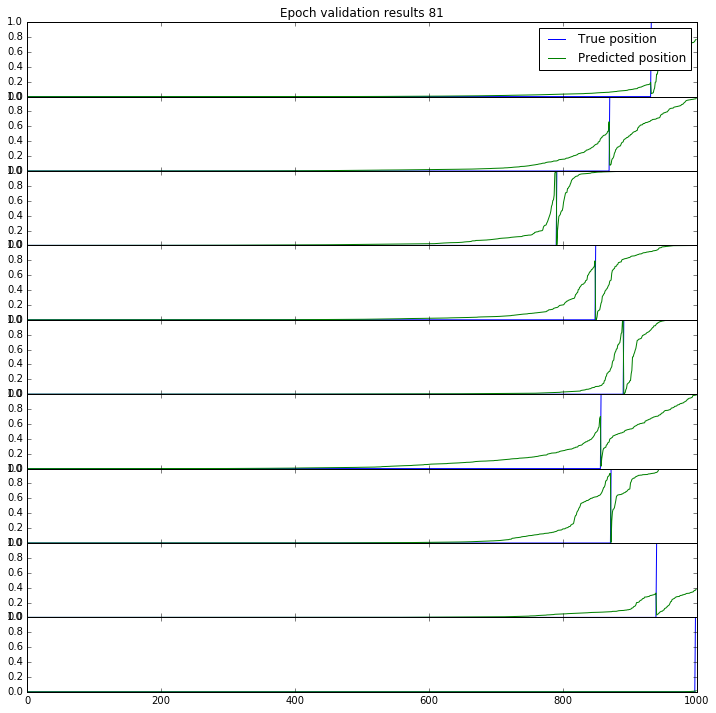

Wrote model to .\Models\weights_81.hdf
Epoch 82/82
753/752 [==============================] - 230s - loss: 1.2306 - categorical_accuracy: 0.5541 - val_loss: 0.4175 - val_categorical_accuracy: 0.8609
Wrote model to .\Models\weights_82.hdf
Epoch 83/83
753/752 [==============================] - 231s - loss: 1.2239 - categorical_accuracy: 0.5510 - val_loss: 0.4213 - val_categorical_accuracy: 0.8668
Wrote model to .\Models\weights_83.hdf
Epoch 84/84
753/752 [==============================] - 229s - loss: 1.2096 - categorical_accuracy: 0.5517 - val_loss: 0.4219 - val_categorical_accuracy: 0.8668
Wrote model to .\Models\weights_84.hdf
Epoch 85/85
753/752 [==============================] - 229s - loss: 1.1941 - categorical_accuracy: 0.5620 - val_loss: 0.4157 - val_categorical_accuracy: 0.8723
Wrote model to .\Models\weights_85.hdf
Epoch 86/86
753/752 [==============================] - 232s - loss: 1.1975 - categorical_accuracy: 0.5620 - val_loss: 0.3949 - val_categorical_accuracy: 0.8742
Wrote

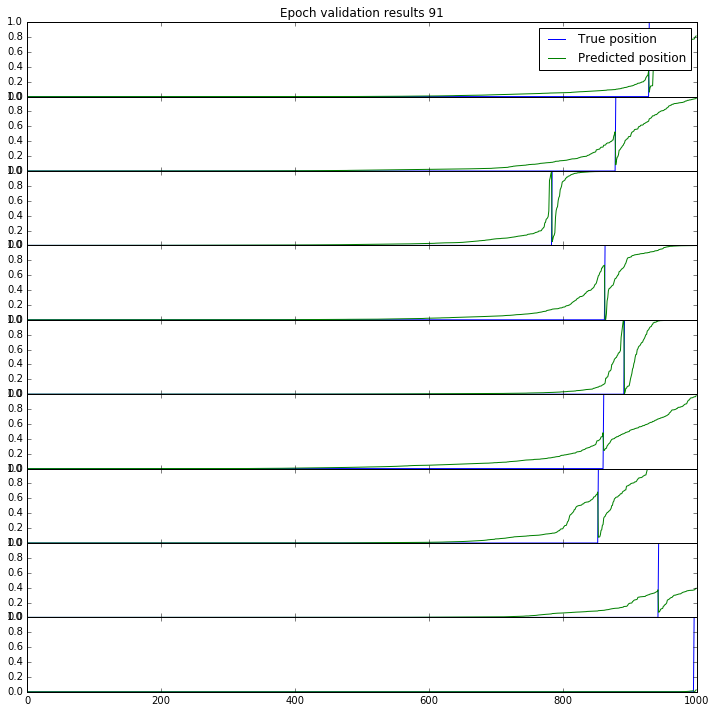

Wrote model to .\Models\weights_91.hdf
Epoch 92/92
753/752 [==============================] - 230s - loss: 1.1409 - categorical_accuracy: 0.5768 - val_loss: 0.3681 - val_categorical_accuracy: 0.8835
Wrote model to .\Models\weights_92.hdf
Epoch 93/93
753/752 [==============================] - 230s - loss: 1.1396 - categorical_accuracy: 0.5835 - val_loss: 0.3836 - val_categorical_accuracy: 0.8641
Wrote model to .\Models\weights_93.hdf
Epoch 94/94
753/752 [==============================] - 229s - loss: 1.1236 - categorical_accuracy: 0.5887 - val_loss: 0.3401 - val_categorical_accuracy: 0.8878
Wrote model to .\Models\weights_94.hdf
Epoch 95/95
753/752 [==============================] - 230s - loss: 1.1193 - categorical_accuracy: 0.5944 - val_loss: 0.3407 - val_categorical_accuracy: 0.8931
Wrote model to .\Models\weights_95.hdf
Epoch 96/96
753/752 [==============================] - 231s - loss: 1.1247 - categorical_accuracy: 0.5819 - val_loss: 0.3560 - val_categorical_accuracy: 0.8832
Wrote

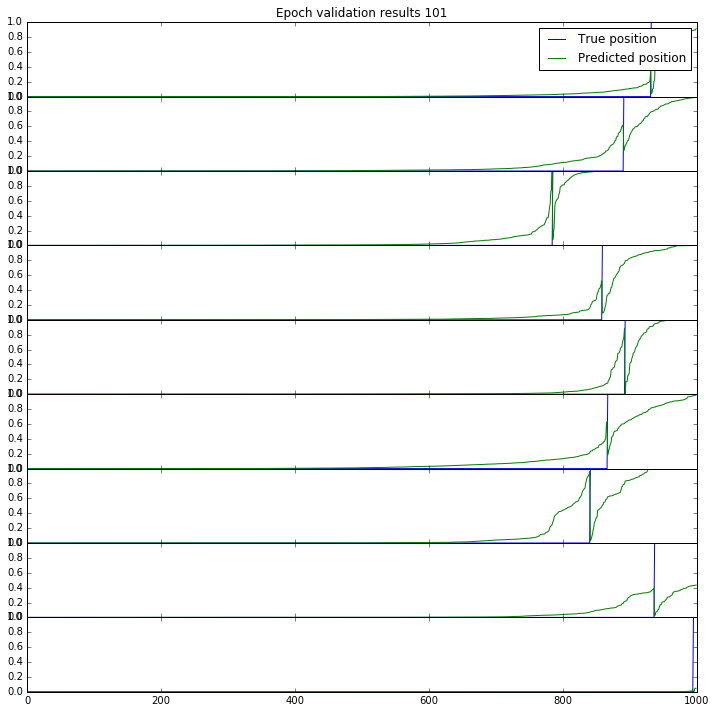

Wrote model to .\Models\weights_101.hdf
Epoch 102/102
753/752 [==============================] - 231s - loss: 1.0814 - categorical_accuracy: 0.6059 - val_loss: 0.3263 - val_categorical_accuracy: 0.8952
Wrote model to .\Models\weights_102.hdf
Epoch 103/103
753/752 [==============================] - 229s - loss: 1.0717 - categorical_accuracy: 0.6096 - val_loss: 0.3177 - val_categorical_accuracy: 0.9003
Wrote model to .\Models\weights_103.hdf
Epoch 104/104
753/752 [==============================] - 230s - loss: 1.0674 - categorical_accuracy: 0.6073 - val_loss: 0.3029 - val_categorical_accuracy: 0.9035
Wrote model to .\Models\weights_104.hdf
Epoch 105/105
753/752 [==============================] - 231s - loss: 1.0578 - categorical_accuracy: 0.6133 - val_loss: 0.3001 - val_categorical_accuracy: 0.8997
Wrote model to .\Models\weights_105.hdf
Epoch 106/106
753/752 [==============================] - 232s - loss: 1.0630 - categorical_accuracy: 0.6096 - val_loss: 0.3050 - val_categorical_accurac

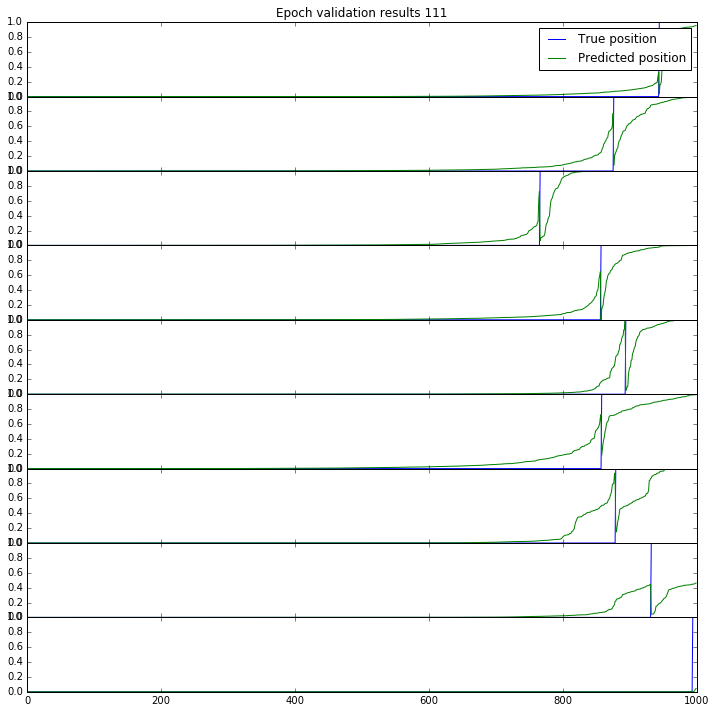

Wrote model to .\Models\weights_111.hdf
Epoch 112/112
753/752 [==============================] - 230s - loss: 1.0190 - categorical_accuracy: 0.6325 - val_loss: 0.2730 - val_categorical_accuracy: 0.9085
Wrote model to .\Models\weights_112.hdf
Epoch 113/113
753/752 [==============================] - 230s - loss: 1.0198 - categorical_accuracy: 0.6269 - val_loss: 0.2736 - val_categorical_accuracy: 0.9077
Wrote model to .\Models\weights_113.hdf
Epoch 114/114
753/752 [==============================] - 230s - loss: 1.0026 - categorical_accuracy: 0.6295 - val_loss: 0.2659 - val_categorical_accuracy: 0.9011
Wrote model to .\Models\weights_114.hdf
Epoch 115/115
753/752 [==============================] - 230s - loss: 1.0095 - categorical_accuracy: 0.6303 - val_loss: 0.2737 - val_categorical_accuracy: 0.8952
Wrote model to .\Models\weights_115.hdf
Epoch 116/116
753/752 [==============================] - 230s - loss: 0.9911 - categorical_accuracy: 0.6369 - val_loss: 0.2795 - val_categorical_accurac

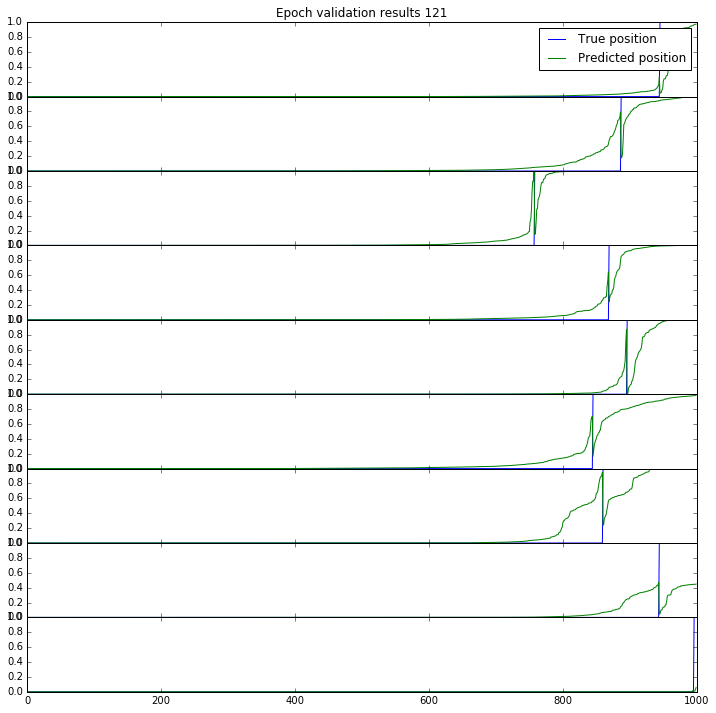

Wrote model to .\Models\weights_121.hdf
Epoch 122/122
753/752 [==============================] - 229s - loss: 0.9678 - categorical_accuracy: 0.6488 - val_loss: 0.2403 - val_categorical_accuracy: 0.9186
Wrote model to .\Models\weights_122.hdf
Epoch 123/123
753/752 [==============================] - 231s - loss: 0.9648 - categorical_accuracy: 0.6479 - val_loss: 0.2428 - val_categorical_accuracy: 0.9199
Wrote model to .\Models\weights_123.hdf
Epoch 124/124
753/752 [==============================] - 229s - loss: 0.9570 - categorical_accuracy: 0.6560 - val_loss: 0.2637 - val_categorical_accuracy: 0.8987
Wrote model to .\Models\weights_124.hdf
Epoch 125/125
753/752 [==============================] - 229s - loss: 0.9486 - categorical_accuracy: 0.6588 - val_loss: 0.2593 - val_categorical_accuracy: 0.9104
Wrote model to .\Models\weights_125.hdf
Epoch 126/126
753/752 [==============================] - 229s - loss: 0.9340 - categorical_accuracy: 0.6615 - val_loss: 0.2254 - val_categorical_accurac

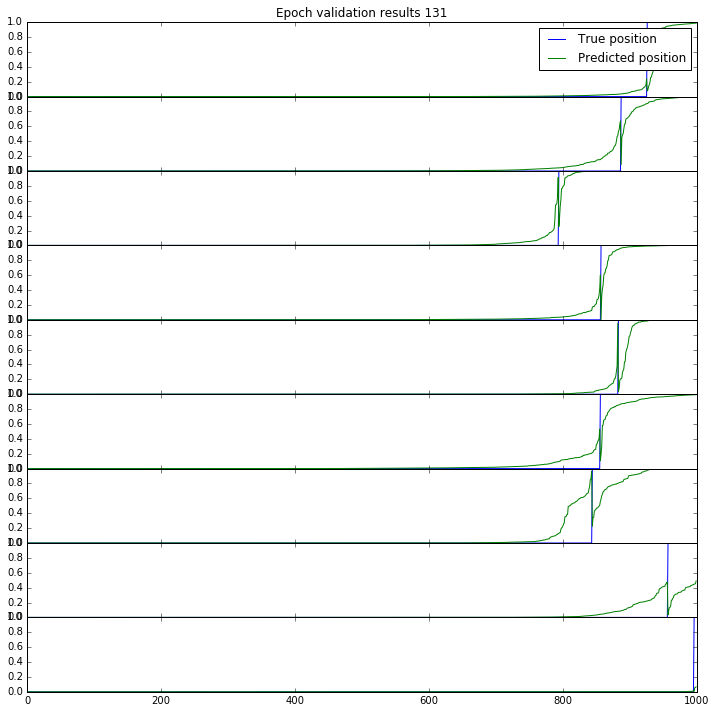

Wrote model to .\Models\weights_131.hdf
Epoch 132/132
753/752 [==============================] - 230s - loss: 0.9133 - categorical_accuracy: 0.6662 - val_loss: 0.2276 - val_categorical_accuracy: 0.9285
Wrote model to .\Models\weights_132.hdf
Epoch 133/133
753/752 [==============================] - 232s - loss: 0.9297 - categorical_accuracy: 0.6613 - val_loss: 0.2363 - val_categorical_accuracy: 0.9282
Wrote model to .\Models\weights_133.hdf
Epoch 134/134
753/752 [==============================] - 232s - loss: 0.9007 - categorical_accuracy: 0.6774 - val_loss: 0.2288 - val_categorical_accuracy: 0.9154
Wrote model to .\Models\weights_134.hdf
Epoch 135/135
753/752 [==============================] - 231s - loss: 0.9098 - categorical_accuracy: 0.6728 - val_loss: 0.2104 - val_categorical_accuracy: 0.9215
Wrote model to .\Models\weights_135.hdf
Epoch 136/136
106/752 [===>..........................] - ETA: 183s - loss: 0.8906 - categorical_accuracy: 0.6741

In [ ]:
# Was ran on the above simple model, not pre-trained Inceptionv3 run.
epoch = 0
#batches_validation_per_epoch = 50
#batches_training_per_epoch = 400
batch_size = 20
batches_training_per_epoch = int(training.length / batch_size) / 5
batches_validation_per_epoch = int(validation.length / batch_size) / 5
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
WEIGHTS_FNAME = '.\\Models\\weights_%i.hdf'
MODELS_FNAME = '.\\Models\\models_%i.h5'

for i in range(500):
    model.fit_generator(
        TrainBatchGen(batch_size, training=training),
        batches_training_per_epoch,
        epochs=epoch+1,
        verbose=1,
        callbacks=None,
        class_weight=None,
        max_q_size=50,
        workers=50,
        validation_data=ValidationBatchGen(batch_size, validation),
        validation_steps = batches_validation_per_epoch,
        pickle_safe=False,
        initial_epoch=epoch)
    
    epoch += 1
    
    # Plot occasional validation data plot
    if i % 10 == 0:
        plot_validate(ValidationBatchGen(batch_size, validation), model, 1000, "Epoch validation results %i" % epoch)
    
    # Save the model
    model.save_weights(WEIGHTS_FNAME % epoch)
    model.save(MODELS_FNAME % epoch)
    print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)



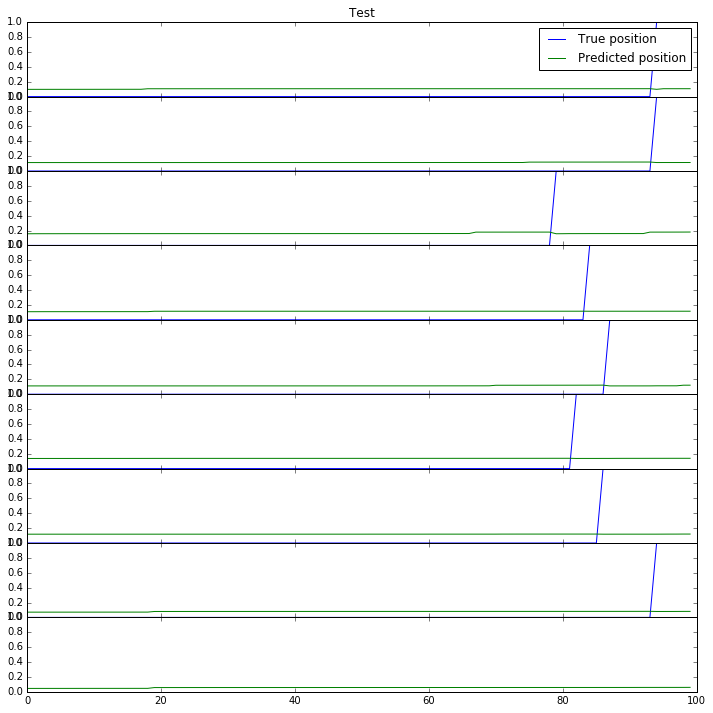

In [33]:
plot_validate(ValidationBatchGen(batch_size, validation), model, 100, "Test")